#**Network Analysis of Harry Potter**
The real data for our project is a collection of .txt files of all of the books in the Harry Potter series: https://github.com/bobdeng/owlreader/tree/master/ERead/assets/books

The character list used to filter out the entities that will become the nodes: https://gist.github.com/jennynz/7eaf7ea4eeb3d686b19e997e721bda0c

###**Questions:**

  1.) Who are the most important characters? (node importance)

  2.) What are the main communities in this network of characters?

  3.) How does the importance of characters evolve over time?

In [1]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# !python3 -m spacy download en_core_web_sm

In [124]:
#Loading spacy English language model
NER = spacy.load("en_core_web_sm") #simple baseline model based on named entity recognition
NER.max_length = 1600000 #Increasing max lenght in order to process longer books

##**I. Processing Text Files to Extract Nodes and Links**
The strategy for processing the text files containing the books of the series is as follows:
* Tokenizing the .txt files into lists of sentences.
* Labeling each sentence with the name of the character(s) appearing in each sentence.
* Defining a window size for how far apart two sentences could be.
  **Rule:** If two characters are mentioned in two sentences within this window, there must be some sort of relationship between them. Using a model based on NER (named entity recognition) we can successfully identify all entities/characters, such as people, organizations or locations.
* Filtering the entities extracted as to only keep the actual character names (For this purpose a character list of 689 characters is used).
After this process the nodes and links are clearly defined and ready for social network analysis.

In [4]:
import os

In [5]:
#Importing all 4 books
all_books = [book for book in os.scandir("./") if ".txt" in book.name] #use "data" if running from an anaconda env

In [6]:
all_books

[<DirEntry '6 Harry Potter and The Half-Blood Prince.txt'>,
 <DirEntry '7 Harry Potter and the Deathly Hallows.txt'>,
 <DirEntry '3 Harry Potter and the Prisoner of Azkaban.txt'>,
 <DirEntry '4 Harry Potter and the Goblet of Fire.txt'>,
 <DirEntry '5 Harry Potter and the Order of the Phoenix.txt'>,
 <DirEntry "1 Harry Potter and the Sorcerer's Stone.txt">,
 <DirEntry '2 Harry Potter and the Chamber of Secrets.txt'>]

In [13]:
all_books[5]

<DirEntry "1 Harry Potter and the Sorcerer's Stone.txt">

In [14]:
all_books[6]

<DirEntry '2 Harry Potter and the Chamber of Secrets.txt'>

In [15]:
all_books[2]

<DirEntry '3 Harry Potter and the Prisoner of Azkaban.txt'>

In [16]:
all_books[3]

<DirEntry '4 Harry Potter and the Goblet of Fire.txt'>

In [17]:
all_books[4]

<DirEntry '5 Harry Potter and the Order of the Phoenix.txt'>

In [18]:
all_books[0]

<DirEntry '6 Harry Potter and The Half-Blood Prince.txt'>

In [19]:
all_books[1]

<DirEntry '7 Harry Potter and the Deathly Hallows.txt'>

*** I will use the following code to transform all books into nodes and edges.

In [201]:
book = all_books[5]
book_text = open(book).read()
book_doc = NER(book_text)

###**Visualizing first 2000 entities identified in the first book**

In [202]:
displacy.render(book_doc[0:2000], style="ent", jupyter=True)

As we can see from the first 2000 characters, there are mostly characters as shown is violet.

Now that I processed the text data let's filter it using the .csv file that contains the character names to find the actual nodes (characters) of the network.

###**Filtering the characters to find nodes based on the all-characters .csv file**

In [203]:
character_df = pd.read_csv("harry_potter_all_characters.csv", header=None)

In [204]:
#Assigning a column name to the DataFrame
character_df.columns = ["character"]

In [205]:
character_df.head(20)

,character
0,Aberforth Dumbledore
1,Abernathy
2,Abraham Peasegood
3,Abraham Potter
4,Abraxas Malfoy
5,Achilles Tolliver
6,Adalbert Waffling
7,Adrian Pucey
8,Adrian Tutley
9,Agatha Chubb


Since the character list is in the right format and requires no cleaning we can proceed to filtering out our nodes. Since some of the characters might be refered to by their first names, I will keep a first name column as well.

In [206]:
#Removing extra information in brackets if existing
import re
character_df['character'] = character_df['character'].apply(lambda x: re.sub("[\(].*?[\)]", "", x))
character_df['character_firstname'] = character_df['character'].apply(lambda x: x.split(' ', 1)[0])

In [207]:
pd.set_option('display.max_rows', None)
character_df.head(20)

,character,character_firstname
0,Aberforth Dumbledore,Aberforth
1,Abernathy,Abernathy
2,Abraham Peasegood,Abraham
3,Abraham Potter,Abraham
4,Abraxas Malfoy,Abraxas
5,Achilles Tolliver,Achilles
6,Adalbert Waffling,Adalbert
7,Adrian Pucey,Adrian
8,Adrian Tutley,Adrian
9,Agatha Chubb,Agatha


In [208]:
character_df.shape

(692, 2)

In [209]:
character_df[character_df["character"] == "Harry Potter"]

,character,character_firstname
348,Harry Potter,Harry


###**Creating the list of entities sentence-by-sentence**

In [210]:
sent_entity_df = []

#Looping through each sentence and storing named entity lists for each sentence
for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"sentence": sent, "entities": entity_list})

sent_entity_df = pd.DataFrame(sent_entity_df)

In [211]:
sent_entity_df.head(20)

,sentence,entities
0,"(Harry, Potter, and, the, Sorcerer, 's, Stone,...","[Harry Potter, CHAPTER ONE, Dursley, number fo..."
1,"(They, were, the, last, people, you, 'd, expec...",[]
2,"(Mr., Dursley, was, the, director, of, a, firm...","[Dursley, Grunnings]"
3,"(He, was, a, big, ,, beefy, man, with, hardly,...",[]
4,"(Mrs., Dursley, was, thin, and, blonde, and, h...",[Dursley]
5,"(The, Dursleys, had, a, small, son, called, Du...","[Dursleys, Dudley]"
6,"(The, Dursleys, had, everything, they, wanted,...",[]
7,"(They, did, n't, think, they, could, bear, it,...",[Potters]
8,"(Mrs., Potter, was, Mrs., Dursley, 's, sister,...","[Potter, Dursley, several years, Dursley]"
9,"(The, Dursleys, shuddered, to, think, what, th...","[Dursleys, Potters]"


###**Filtering out each entity that is not a character**

In [212]:
#Filtering out non-character entities
def filter_entity(ent_list, character_df):
    return [ent for ent in ent_list
            if ent in list(character_df.character)
            or ent in list(character_df.character_firstname)]

In [213]:
filter_entity(["Harry Potter", "She", "2"], character_df)

['Harry Potter']

In [214]:
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df))

#Filtering out sentences that don't have any entities
sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
sent_entity_df_filtered.head(20)

,sentence,entities,character_entities
0,"(Harry, Potter, and, the, Sorcerer, 's, Stone,...","[Harry Potter, CHAPTER ONE, Dursley, number fo...",[Harry Potter]
5,"(The, Dursleys, had, a, small, son, called, Du...","[Dursleys, Dudley]",[Dudley]
11,"(This, boy, was, another, good, reason, for, k...","[Potters, Dudley]",[Dudley]
13,"(Mr., Dursley, hummed, as, he, picked, out, hi...","[Dursley, Dursley, Dudley]",[Dudley]
15,"(At, half, past, eight, ,, Mr., Dursley, picke...","[Dursley, Dursley, Dudley, Dudley]","[Dudley, Dudley]"
54,"("", The, Potters, ,, that, 's, right, ,, that,...","[The Potters, Harry, Dursley]",[Harry]
61,"(He, was, sure, there, were, lots, of, people,...",[Harry],[Harry]
62,"(Come, to, think, \n, of, it, ,, he, was, n't,...",[Harry],[Harry]
64,"(It, might, have, been, Harvey, .)",[Harvey],[Harvey]
65,"(Or, Harold, .)",[Harold],[Harold]


Since there are a few instances where one character appears by their first name and by their full name as well, such as 'Vernon Dursley' and 'Vernon', I will specify that all characters will be denoted by their full names from now on, to filter out duplicate values. In the Harry Potter universe, some characters have the same first names as others - such as Harry's son in the later books has the same name as Harry's beloved professors - this way we can eliminate the chance of loosing characters.

In [215]:
#Take the full name of characters
character_names = character_df['character'].tolist()

#Filtering 'character_entities' column based on character_names
sent_entity_df_filtered.loc[:, 'character_entities'] = sent_entity_df_filtered['character_entities'].apply(
    lambda x: [item for item in x if item in character_names]
)

In [216]:
pd.reset_option('^display.', silent=True)
sent_entity_df_filtered

,sentence,entities,character_entities
0,"(Harry, Potter, and, the, Sorcerer, 's, Stone,...","[Harry Potter, CHAPTER ONE, Dursley, number fo...",[Harry Potter]
5,"(The, Dursleys, had, a, small, son, called, Du...","[Dursleys, Dudley]",[]
11,"(This, boy, was, another, good, reason, for, k...","[Potters, Dudley]",[]
13,"(Mr., Dursley, hummed, as, he, picked, out, hi...","[Dursley, Dursley, Dudley]",[]
15,"(At, half, past, eight, ,, Mr., Dursley, picke...","[Dursley, Dursley, Dudley, Dudley]",[]
...,...,...,...
5965,"("", You, must, be, Harry, 's, family, !, "", sa...","[Harry, Weasley]",[]
5969,"(Harry, hung, back, for, a, last, word, with, ...","[Harry hung, Ron]",[]
5971,"("", \n, "", Hope, you, have, --, er, --, a, goo...","[Hermione, Uncle Vernon]",[]
5972,"("", Oh, ,, I, will, ,, "", said, Harry, ,, and,...",[Harry],[]


In [217]:
pd.reset_option('^display.', silent=True)
sent_entity_df_filtered

,sentence,entities,character_entities
0,"(Harry, Potter, and, the, Sorcerer, 's, Stone,...","[Harry Potter, CHAPTER ONE, Dursley, number fo...",[Harry Potter]
5,"(The, Dursleys, had, a, small, son, called, Du...","[Dursleys, Dudley]",[]
11,"(This, boy, was, another, good, reason, for, k...","[Potters, Dudley]",[]
13,"(Mr., Dursley, hummed, as, he, picked, out, hi...","[Dursley, Dursley, Dudley]",[]
15,"(At, half, past, eight, ,, Mr., Dursley, picke...","[Dursley, Dursley, Dudley, Dudley]",[]
...,...,...,...
5965,"("", You, must, be, Harry, 's, family, !, "", sa...","[Harry, Weasley]",[]
5969,"(Harry, hung, back, for, a, last, word, with, ...","[Harry hung, Ron]",[]
5971,"("", \n, "", Hope, you, have, --, er, --, a, goo...","[Hermione, Uncle Vernon]",[]
5972,"("", Oh, ,, I, will, ,, "", said, Harry, ,, and,...",[Harry],[]


###**Extracting relatioships (links) based on the characters (nodes) that are identified in the text**

 After removing duplicated characters, I will form the links based on characters from the same window. I will form relationships based on characters that are in a window of 5 sentences.

In [218]:
window_size = 5
relationships = []

for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), [])

    #Removing duplicated characters that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list))
                   if (i==0) or char_list[i] != char_list[i-1]]

    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})

In [219]:
relationship_df = pd.DataFrame(relationships)

In [220]:
pd.set_option('display.max_rows', None)
relationship_df

,source,target
0,Harry Potter,Dudley Dursley
1,Harry Potter,Dudley Dursley
2,Harry Potter,Dudley Dursley
3,Dudley Dursley,Harry Potter
4,Dudley Dursley,Harry Potter
5,Dudley Dursley,Harry Potter
6,Dudley Dursley,Harry Potter
7,Tibbles,Snowy
8,Snowy,Tufty
9,Tibbles,Snowy


One last thing that I have to do is to remove any duplicate relationships. I will do this whilst creating a weigh for our edges to store how strong the relationship is.

In [221]:
#Sorting the cases where the nodes in the links are in inverted order
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), columns = relationship_df.columns)
relationship_df

,source,target
0,Dudley Dursley,Harry Potter
1,Dudley Dursley,Harry Potter
2,Dudley Dursley,Harry Potter
3,Dudley Dursley,Harry Potter
4,Dudley Dursley,Harry Potter
5,Dudley Dursley,Harry Potter
6,Dudley Dursley,Harry Potter
7,Snowy,Tibbles
8,Snowy,Tufty
9,Snowy,Tibbles


In [222]:
relationship_df["value"] = 1
relationship_df = relationship_df.groupby(["source","target"], sort=False, as_index=False).sum()

In [223]:
relationship_df.head(20)

,source,target,value
0,Dudley Dursley,Harry Potter,7
1,Snowy,Tibbles,6
2,Snowy,Tufty,6
3,Harry Potter,James Potter,3
4,Adalbert Waffling,Miranda Goshawk,5
5,Adalbert Waffling,Newt Scamander,6
6,Newt Scamander,Quentin Trimble,6
7,Dedalus Diggle,Doris Crockford,6
8,George Weasley,Harry Potter,2
9,Albus Dumbledore,Nicolas Flamel,3


In [227]:
relationship_df.to_csv("book1.csv", index=False)

In [228]:
relationship_df

,source,target,value
0,Dudley Dursley,Harry Potter,7
1,Snowy,Tibbles,6
2,Snowy,Tufty,6
3,Harry Potter,James Potter,3
4,Adalbert Waffling,Miranda Goshawk,5
5,Adalbert Waffling,Newt Scamander,6
6,Newt Scamander,Quentin Trimble,6
7,Dedalus Diggle,Doris Crockford,6
8,George Weasley,Harry Potter,2
9,Albus Dumbledore,Nicolas Flamel,3


###**Visualizing the Network of the First Book**

In [229]:
G = nx.from_pandas_edgelist(relationship_df, source="source", target="target", edge_attr="value", create_using=nx.Graph())

In [230]:
len(G.nodes()), len(G.edges())

(46, 51)

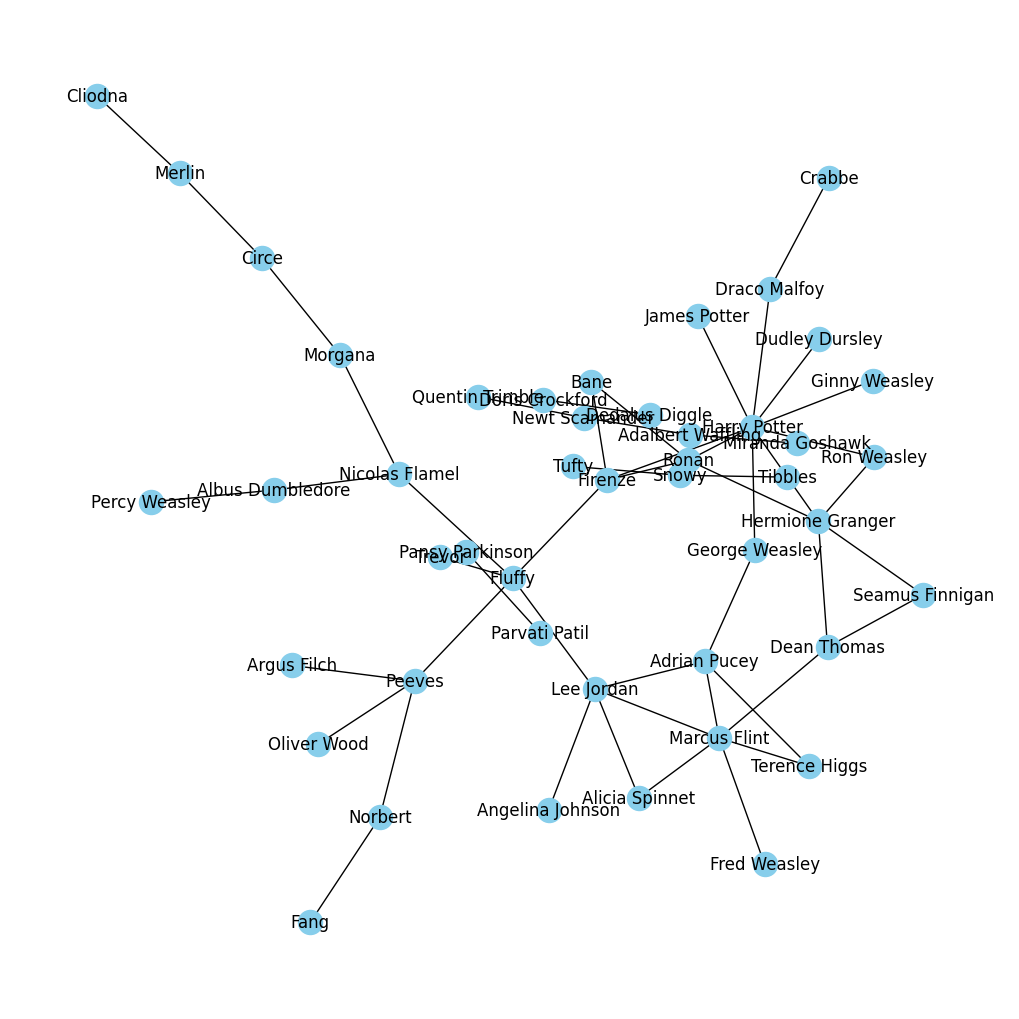

In [231]:
plt.figure(figsize=(10, 10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color="skyblue", edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

The above visualization is hard to understand since there are many overlapping node-labels and edges so I will try a different technique to better visualize the Harry Potter Universe Network.

##**II. Creating an interactive visualization of the Network of Harry Potter Universe using Pyvis**

In [232]:
!pip install pyvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.9 MB/s eta 0:00:00


In [233]:
from pyvis.network import Network

Here the weight of the edges refers to how many times the characters interacted in the books (how many times they appear between a window size of 5 lines), whilst the size of the node represents the degree.

In [234]:
dict(G.degree)

{'Dudley Dursley': 1,
 'Harry Potter': 9,
 'Snowy': 2,
 'Tibbles': 1,
 'Tufty': 1,
 'James Potter': 1,
 'Adalbert Waffling': 2,
 'Miranda Goshawk': 1,
 'Newt Scamander': 2,
 'Quentin Trimble': 1,
 'Dedalus Diggle': 1,
 'Doris Crockford': 1,
 'George Weasley': 2,
 'Albus Dumbledore': 2,
 'Nicolas Flamel': 3,
 'Morgana': 2,
 'Circe': 2,
 'Merlin': 2,
 'Cliodna': 1,
 'Hermione Granger': 5,
 'Ron Weasley': 2,
 'Crabbe': 1,
 'Draco Malfoy': 2,
 'Percy Weasley': 1,
 'Argus Filch': 1,
 'Peeves': 4,
 'Seamus Finnigan': 2,
 'Dean Thomas': 3,
 'Pansy Parkinson': 1,
 'Parvati Patil': 1,
 'Oliver Wood': 1,
 'Angelina Johnson': 1,
 'Lee Jordan': 5,
 'Alicia Spinnet': 2,
 'Marcus Flint': 6,
 'Adrian Pucey': 4,
 'Fred Weasley': 1,
 'Terence Higgs': 2,
 'Fluffy': 5,
 'Fang': 1,
 'Norbert': 2,
 'Ronan': 4,
 'Bane': 2,
 'Firenze': 4,
 'Trevor': 1,
 'Ginny Weasley': 1}

In [235]:
net = Network(notebook=True, width="100vw", height="100vh", bgcolor="#222222", font_color="white", cdn_resources='in_line')
node_degree=dict(G.degree)
nx.set_node_attributes(G, node_degree, "size")
net.from_nx(G)
net.show("harry_potter.html")

harry_potter.html


##**III. Identifying the Most Important Characters Based on Centrality Measures**

* Who are the most important characters based on the four centrality measures?
(When presenting make sure the same nodes are colored the same in the table of top 10 nodes!!!)

In [236]:
import seaborn as sns

sns.set_style("whitegrid")
#sns.set_palette("tab20b")
sns.set_palette("Paired")

In [237]:
sns.color_palette()

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [238]:
palette = sns.color_palette()

###**TOP 10 Characters Based on Degree Centrality**

In [239]:
degree_dict = nx.degree_centrality(G)

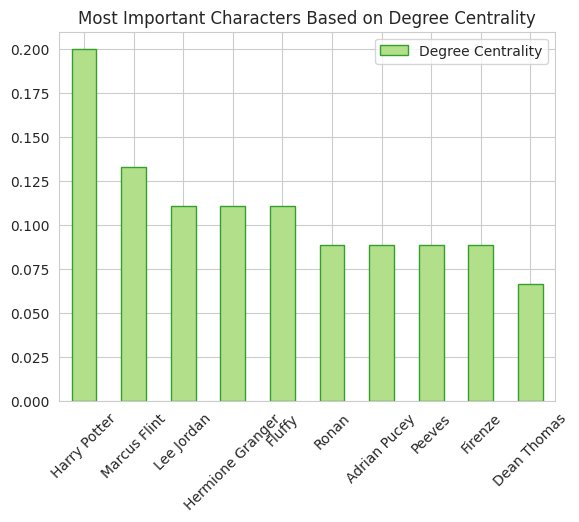

In [240]:
degree_df = pd.DataFrame.from_dict(degree_dict, orient="index", columns=["Degree Centrality"])
degree_df.sort_values("Degree Centrality", ascending=False)[0:10].plot(kind="bar", color=palette[2], edgecolor=palette[3])
plt.title("Most Important Characters Based on Degree Centrality")
plt.xticks(rotation=45)
plt.show()

###**TOP 10 Characters Based on Betweenness Centrality**

In [241]:
betweenness_dict = nx.betweenness_centrality(G)

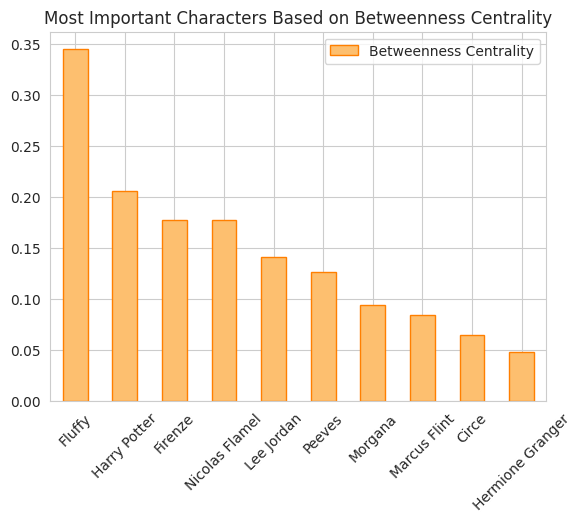

In [242]:
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient="index", columns=["Betweenness Centrality"])
betweenness_df.sort_values("Betweenness Centrality", ascending=False)[0:10].plot(kind="bar", color=palette[6], edgecolor=palette[7])
plt.title("Most Important Characters Based on Betweenness Centrality")
plt.xticks(rotation=45)
plt.show()

###**TOP 10 Characters Based on Closeness Centrality**

In [243]:
closeness_dict = nx.closeness_centrality(G)

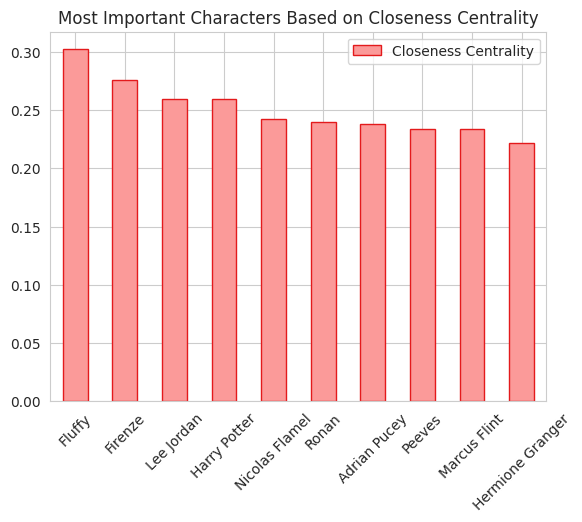

In [244]:
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient="index", columns=["Closeness Centrality"])
closeness_df.sort_values("Closeness Centrality", ascending=False)[0:10].plot(kind="bar", color=palette[4], edgecolor=palette[5])
plt.title("Most Important Characters Based on Closeness Centrality")
plt.xticks(rotation=45)
plt.show()

###**TOP 10 Characters Based on Eigenvector Centrality**

In [245]:
eigenvector_dict = nx.eigenvector_centrality(G)

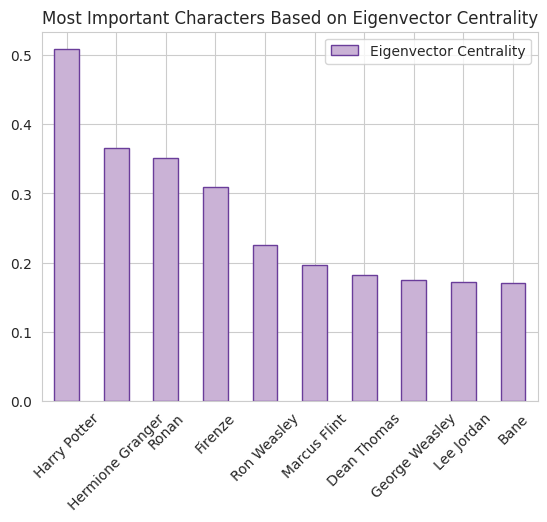

In [246]:
eigenvector_df = pd.DataFrame.from_dict(eigenvector_dict, orient="index", columns=["Eigenvector Centrality"])
eigenvector_df.sort_values("Eigenvector Centrality", ascending=False)[0:10].plot(kind="bar", color=palette[8], edgecolor=palette[9])
plt.title("Most Important Characters Based on Eigenvector Centrality")
plt.xticks(rotation=45)
plt.show()

In [247]:
#Saving centrality measures to the node attributes

nx.set_node_attributes(G, degree_dict, "degree_centrality")
nx.set_node_attributes(G, betweenness_dict, "betweenness_centrality")
nx.set_node_attributes(G, closeness_dict, "closeness_centrality")
nx.set_node_attributes(G, eigenvector_dict, "eigenvector_centrality")

##**IV. Community Detection**

In [248]:
!pip install python-igraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 11.4 MB/s eta 0:00:00


In [249]:
import igraph as ig

In [250]:
ig_graph = ig.Graph.from_networkx(G)
communities = ig_graph.community_multilevel()

In [251]:
character_community_dict = {}

In [252]:
for community_number, community in enumerate(communities):
    for character_id in community:
        character_name = list(G.nodes())[character_id]
        character_community_dict[character_name] = community_number

In [253]:
character_community_dict

{'Dudley Dursley': 0,
 'Harry Potter': 0,
 'James Potter': 0,
 'George Weasley': 0,
 'Crabbe': 0,
 'Draco Malfoy': 0,
 'Ronan': 0,
 'Bane': 0,
 'Firenze': 0,
 'Ginny Weasley': 0,
 'Snowy': 1,
 'Tibbles': 1,
 'Tufty': 1,
 'Adalbert Waffling': 2,
 'Miranda Goshawk': 2,
 'Newt Scamander': 2,
 'Quentin Trimble': 2,
 'Dedalus Diggle': 3,
 'Doris Crockford': 3,
 'Albus Dumbledore': 4,
 'Nicolas Flamel': 4,
 'Morgana': 4,
 'Circe': 4,
 'Merlin': 4,
 'Cliodna': 4,
 'Percy Weasley': 4,
 'Fluffy': 4,
 'Trevor': 4,
 'Hermione Granger': 5,
 'Ron Weasley': 5,
 'Seamus Finnigan': 5,
 'Dean Thomas': 5,
 'Argus Filch': 6,
 'Peeves': 6,
 'Oliver Wood': 6,
 'Fang': 6,
 'Norbert': 6,
 'Pansy Parkinson': 7,
 'Parvati Patil': 7,
 'Angelina Johnson': 8,
 'Lee Jordan': 8,
 'Alicia Spinnet': 8,
 'Marcus Flint': 8,
 'Adrian Pucey': 8,
 'Fred Weasley': 8,
 'Terence Higgs': 8}

In [254]:
len(character_community_dict), len(G.nodes())

(46, 46)

Using the following code the different communities will be assigned different colors.

In [255]:
net = Network(notebook=True, width="100vw", height="100vh", bgcolor="#222222", font_color="white", cdn_resources='in_line')
node_degree=dict(G.degree)
nx.set_node_attributes(G, node_degree, "size")
nx.set_node_attributes(G, character_community_dict, "group")
net.from_nx(G)
net.show("harry_potter_communities.html")

harry_potter_communities.html


##**V. Analyzing the Evoltion of Character Influence Over Time**
To analyze the change of our network over the course of the first four books I will create four separate graphs named G1, G2, G3 and G4.

###**Visualizing All Harry Potter Book Networks**

In [256]:
from pyvis.network import Network

In [257]:
g1 = pd.read_csv("book1.csv")

In [258]:
G1 = nx.from_pandas_edgelist(g1, source="source", target="target", edge_attr="value", create_using=nx.Graph())

In [259]:
len(G1.nodes()), len(G1.edges())

(46, 51)

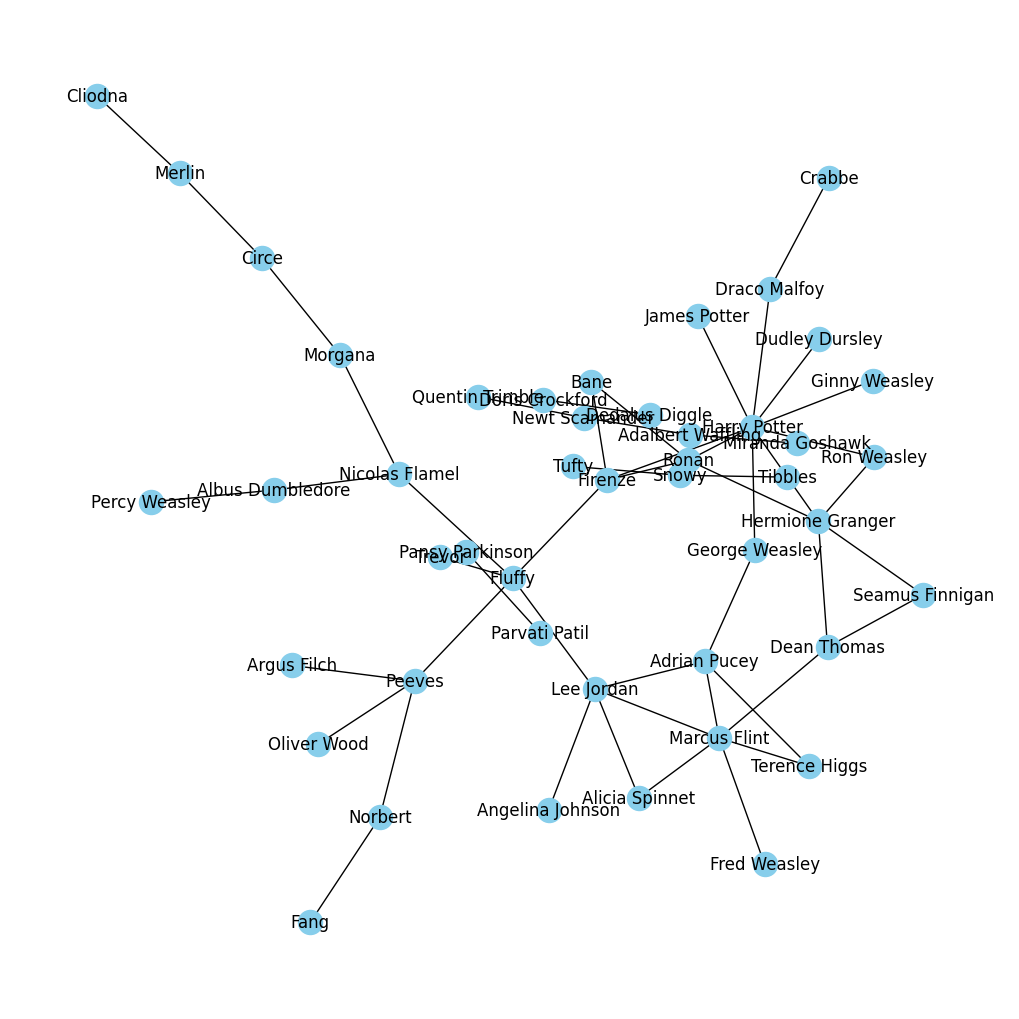

In [260]:
plt.figure(figsize=(10, 10))
pos = nx.kamada_kawai_layout(G1)
nx.draw(G1, with_labels=True, node_color="skyblue", edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

In [262]:
net = Network(notebook=True, width="100vw", height="100vh", bgcolor="#222222", font_color="white", cdn_resources='in_line')
node_degree=dict(G1.degree)
nx.set_node_attributes(G1, node_degree, "size")
net.from_nx(G1)
net.show("harry_potter_1.html")

harry_potter_1.html


###**Plotting the Degree Centrality Measure of All Harry Potter Books**

##**Merging All Four Edgelists Into One Big Network of the Harry Potter Universe**

In [263]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx
import matplotlib.pyplot as plt

In [264]:
df1 = pd.read_csv('book1.csv', names=['source', 'target', 'value'], skiprows=1)
df2 = pd.read_csv('book2.csv', names=['source', 'target', 'value'], skiprows=1)
df3 = pd.read_csv('book3.csv', names=['source', 'target', 'value'], skiprows=1)
df4 = pd.read_csv('book4.csv', names=['source', 'target', 'value'], skiprows=1)
df5 = pd.read_csv('book5.csv', names=['source', 'target', 'value'], skiprows=1)
df6 = pd.read_csv('book6.csv', names=['source', 'target', 'value'], skiprows=1)
df7 = pd.read_csv('book7.csv', names=['source', 'target', 'value'], skiprows=1)

#Converting 'value' column to integers
df1['value'] = df1['value'].astype(int)
df2['value'] = df2['value'].astype(int)
df3['value'] = df3['value'].astype(int)
df4['value'] = df4['value'].astype(int)
df5['value'] = df5['value'].astype(int)
df6['value'] = df6['value'].astype(int)
df7['value'] = df7['value'].astype(int)

#Concatenating DataFrames
merged_df = pd.concat([df1, df2, df3, df4, df5, df6, df7])

#Grouping by 'source' and 'target' columns and aggregate the 'value' column by summing
merged_df = merged_df.groupby(['source', 'target']).sum().reset_index()
merged_df.to_csv('merged_network.csv', index=False)

In [265]:
df1[df1["source"] == "Harry Potter"]

,source,target,value
3,Harry Potter,James Potter,3
15,Harry Potter,Ron Weasley,5
40,Harry Potter,Ronan,4
41,Harry Potter,Hermione Granger,9


In [266]:
df2[df2["source"] == "Harry Potter"]

,source,target,value
0,Harry Potter,Vernon Dursley,1
18,Harry Potter,Justin Finch-Fletchley,5
19,Harry Potter,Ron Weasley,5
56,Harry Potter,Salazar Slytherin,2
62,Harry Potter,Lucius Malfoy,8


In [267]:
df3[df3["source"] == "Harry Potter"]

,source,target,value
36,Harry Potter,James Potter,2
44,Harry Potter,Lee Jordan,5
45,Harry Potter,Katie Bell,4
49,Harry Potter,Sirius Black,11


In [268]:
df4[df4["source"] == "Harry Potter"]

,source,target,value
1,Harry Potter,Nagini,8
3,Harry Potter,Hedwig,4
19,Harry Potter,Hermione Granger,6
20,Harry Potter,Ludo Bagman,5
26,Harry Potter,Winky,64
67,Harry Potter,Mad-Eye Moody,4
75,Harry Potter,Rita Skeeter,18
97,Harry Potter,Peeves,4
101,Harry Potter,Viktor Krum,7
109,Harry Potter,Pansy Parkinson,2


In [269]:
df5[df5["source"] == "Harry Potter"]

,source,target,value
9,Harry Potter,Kreacher,24
58,Harry Potter,Sturgis Podmore,2
84,Harry Potter,Winky,5
164,Harry Potter,Ron Weasley,6
169,Harry Potter,Luna Lovegood,2


In [270]:
df6[df6["source"] == "Harry Potter"]

,source,target,value
3,Harry Potter,Sirius Black,2
8,Harry Potter,Horace Slughorn,5
16,Harry Potter,Pansy Parkinson,5
17,Harry Potter,Nearly Headless Nick,3
41,Harry Potter,Sanguini,5
48,Harry Potter,Kreacher,23


In [271]:
df7[df7["source"] == "Harry Potter"]

,source,target,value
0,Harry Potter,Severus Snape,3
2,Harry Potter,Yaxley,13
23,Harry Potter,Kendra Dumbledore,5
48,Harry Potter,Selwyn,6
56,Harry Potter,Xenophilius Lovegood,9
60,Harry Potter,Scabior,4
61,Harry Potter,Lucius Malfoy,7
73,Harry Potter,Travers,5
91,Harry Potter,Lee Jordan,5
105,Harry Potter,Nagini,4


In [272]:
hp_network = pd.read_csv("merged_network.csv")

In [273]:
hp_network[hp_network["source"] == "Harry Potter"]

,source,target,value
411,Harry Potter,Hedwig,4
412,Harry Potter,Hermione Granger,15
413,Harry Potter,Horace Slughorn,5
414,Harry Potter,James Potter,5
415,Harry Potter,Justin Finch-Fletchley,5
416,Harry Potter,Katie Bell,4
417,Harry Potter,Kendra Dumbledore,5
418,Harry Potter,Kreacher,47
419,Harry Potter,Lee Jordan,10
420,Harry Potter,Lucius Malfoy,15


Looks like the merging of the four networks was successful.

In [274]:
hp_network.shape

(605, 3)

In [275]:
G = nx.from_pandas_edgelist(hp_network, source="source", target="target", edge_attr="value", create_using=nx.Graph())

In [276]:
len(G.nodes()), len(G.edges())

(252, 605)

In [277]:
# plt.figure(figsize=(10, 10))
# pos = nx.kamada_kawai_layout(G)
# nx.draw(G, with_labels=True, node_color="skyblue", edge_cmap=plt.cm.Blues, pos=pos)
# plt.show()

In [278]:
from pyvis.network import Network

net = Network(notebook=True, width="100vw", height="100vh", bgcolor="#222222", font_color="white", cdn_resources='in_line')
node_degree=dict(G.degree)
nx.set_node_attributes(G, node_degree, "size")
net.from_nx(G)
net.show("harry_potter_universe.html")

harry_potter_universe.html


**Detecting the Communities within the Network**

In [279]:
# !pip install igraph

In [280]:
import igraph as ig

In [281]:
ig_graph = ig.Graph.from_networkx(G)
communities = ig_graph.community_multilevel()

In [282]:
character_community_dict = {}

In [283]:
for community_number, community in enumerate(communities):
    for character_id in community:
        character_name = list(G.nodes())[character_id]
        character_community_dict[character_name] = community_number

In [284]:
character_community_dict

{'Adalbert Waffling': 0,
 'Bathilda Bagshot': 0,
 'Miranda Goshawk': 0,
 'Newt Scamander': 0,
 'Gellert Grindelwald': 0,
 'Nicolas Flamel': 0,
 'Xenophilius Lovegood': 0,
 'Alecto Carrow': 0,
 'Merlin': 0,
 'Ambrosius Flume': 0,
 'Barnabas Cuffe': 0,
 'Gwenog Jones': 0,
 'Ariana Dumbledore': 0,
 'Ted Tonks': 0,
 'Auntie Muriel': 0,
 'Dirk Cresswell': 0,
 'Gornuk': 0,
 'Beedle the Bard': 0,
 'Circe': 0,
 'Morgana': 0,
 'Cliodna': 0,
 'Gilderoy Lockhart': 0,
 'Williamson': 0,
 'Wilbert Slinkhard': 0,
 'Quentin Trimble': 0,
 'Adrian Pucey': 1,
 'George Weasley': 1,
 'Lee Jordan': 1,
 'Marcus Flint': 1,
 'Terence Higgs': 1,
 'Alicia Spinnet': 1,
 'Angelina Johnson': 1,
 'Cho Chang': 1,
 'Geoffrey Hooper': 1,
 'Katie Bell': 1,
 'Luna Lovegood': 1,
 'Miles Bletchley': 1,
 'Warrington': 1,
 'Montague': 1,
 'Anthony Goldstein': 1,
 'Ernie Macmillan': 1,
 'Michael Corner': 1,
 'Terry Boot': 1,
 'Zacharias Smith': 1,
 'Oliver Wood': 1,
 'Barry Ryan': 1,
 'Bletchley': 1,
 'Bole': 1,
 'Derrick': 1

In [285]:
len(character_community_dict), len(G.nodes())

(252, 252)

In [286]:
net = Network(notebook=True, width="100vw", height="100vh", bgcolor="#222222", font_color="white", cdn_resources='in_line')
node_degree=dict(G.degree)
nx.set_node_attributes(G, node_degree, "size")
nx.set_node_attributes(G, character_community_dict, "group")
net.from_nx(G)
net.show("harry_potter_universe_communities.html")

harry_potter_universe_communities.html
